## Завантаження необхідних бібліотек

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Завантаження та обробка даних

In [3]:
df = pd.read_excel('/kaggle/input/data-news/data/texts_emotions.xlsx', index_col='id')

In [4]:
df.head()

,message,em_1,em_2,em_3,em_4,em_5,em_6,em_7,em_8,em_9,em_10,em_11
id,,,,,,,,,,,,
1,"Сумська область, Неділя 30 квітня 2023 23:59 ...",0,0,0,2,3,1,2,0,0,0,0
2,30.04.2023 23:40 Загарбники збільшили кількіс...,0,0,0,0,3,2,1,2,0,0,0
3,"30.04.2023, 23:51 Дмитро Лубінець (Фото: Face...",0,0,0,2,2,1,2,0,0,0,0
4,"Катерина Присяжнюк 23:44, 30.04.23 Мер Павло...",0,0,0,2,1,0,2,1,0,0,0
5,"Лариса Козова 23:43, 30.04.23 Підводні човни...",0,0,0,2,2,1,1,2,0,0,0


In [5]:
# функція для обробки цільових змінних
def transform_labels(row):
    max_val = row.max()
    return (row == max_val).astype(int)

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Завантаження стоп-слів (список слів було взято за [посиланням](https://github.com/skupriienko/Ukrainian-Stopwords/blob/master/stopwords_ua.txt))

In [46]:
# функція для зчитування списку стоп-слів
def load_stop_words(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stop_words = set(word.strip() for word in file)
    return stop_words

In [9]:
# Функція для очищення тексту
def clean_text(text):
    # Видалення URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Видалення спеціальних символів і чисел
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Перетворення тексту до нижнього регістру
    text = text.lower()
    # Токенізація
    tokens = word_tokenize(text)
    # Видалення стоп-слів
    stop_words = load_stop_words('/kaggle/input/data-news/stopwords_ua (1).txt')
    tokens = [word for word in tokens if word not in stop_words]
    # Стемінг
    # Ініціалізація стеммера
    stemmer = SnowballStemmer("russian")
    tokens = [stemmer.stem(word) for word in tokens]
    # Об'єднання токенів назад у текст
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [13]:
X = df['message'].apply(clean_text)
labels = df.drop(columns='message').apply(transform_labels, axis=1).values

In [15]:
X[:1], labels[:1]

(id
 1    сумськ област неділ квітня фот окупант обстріл...
 Name: message, dtype: object,
 array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

2024-05-28 12:30:04.467277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 12:30:04.467418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 12:30:04.587258: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [47]:
# токенізація та ривівнювання довжини усіх навчальних послідовностей
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=200, truncating='post')

In [18]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return text, label

In [19]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Створення наборів даних і завантажувачів
train_dataset = TextDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.float))
test_dataset = TextDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.float))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Визначення архітектури мережі

In [49]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(0.9)
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [61]:
vocab_size = 10000 
embed_size = 64
hidden_size = 64
num_classes = labels.shape[1]

model = TextClassificationModel(vocab_size, embed_size, hidden_size, num_classes)
model.to(device)
criterion = nn.BCELoss()

Epoch [1/10], Train Loss: 0.6359, Test Loss: 0.6488, Train Acc: 0.7371, Test Acc: 0.8001
Epoch [2/10], Train Loss: 0.5514, Test Loss: 0.5854, Train Acc: 0.8411, Test Acc: 0.8600
Epoch [3/10], Train Loss: 0.4557, Test Loss: 0.4987, Train Acc: 0.8502, Test Acc: 0.8607
Epoch [4/10], Train Loss: 0.4040, Test Loss: 0.4436, Train Acc: 0.8508, Test Acc: 0.8607
Epoch [5/10], Train Loss: 0.3876, Test Loss: 0.4195, Train Acc: 0.8506, Test Acc: 0.8607
Epoch [6/10], Train Loss: 0.3790, Test Loss: 0.4078, Train Acc: 0.8512, Test Acc: 0.8607
Epoch [7/10], Train Loss: 0.3717, Test Loss: 0.3983, Train Acc: 0.8504, Test Acc: 0.8607
Epoch [8/10], Train Loss: 0.3685, Test Loss: 0.3939, Train Acc: 0.8506, Test Acc: 0.8607
Epoch [9/10], Train Loss: 0.3673, Test Loss: 0.3886, Train Acc: 0.8502, Test Acc: 0.8607
Epoch [10/10], Train Loss: 0.3669, Test Loss: 0.3866, Train Acc: 0.8515, Test Acc: 0.8607


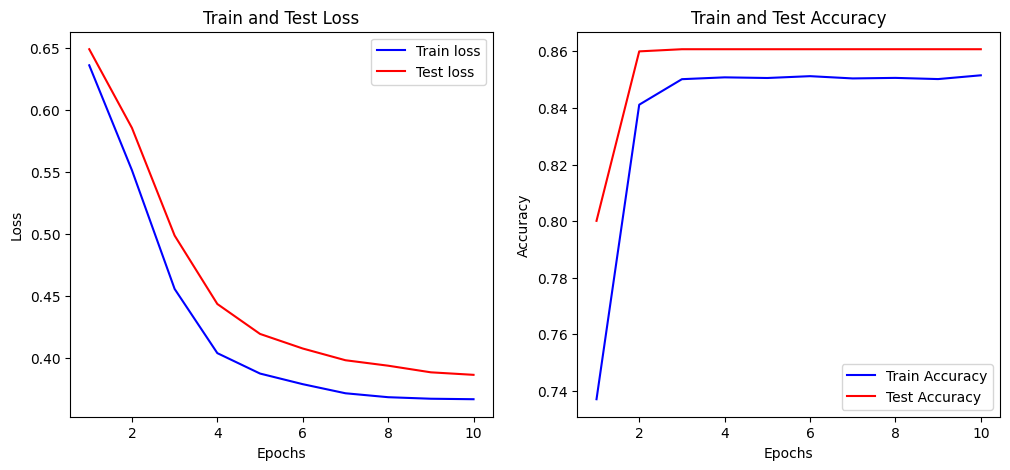

In [62]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total_train += labels.size(0) * labels.size(1)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Оцінка моделі на тестовому наборі
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_test += labels.size(0) * labels.size(1)
            correct_test += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}')

# Побудова графіків
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Train loss')
plt.plot(epochs, test_losses, 'r', label='Test loss')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, test_accuracies, 'r', label='Test Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [63]:
torch.save(model, "/kaggle/working/nlp_model.pth")